# MCR ALS

In [1]:
import spectrochempy as scp

## Introduction

MCR-ALS (standing for Multivariate Curve Resolution - Alternating Least Squares) is a
popular method for resolving a set (or several sets) of spectra $X$ of an evolving
mixture (or a set of mixtures) into the spectra $S^t$ of 'pure'
species and their concentration profiles $C$. In terms of matrix equation:

$$ X = C.S^t + E $$

The ALS algorithm allows applying soft or hard constraints (e.g., non negativity,
unimodality, equality to a given profile) to the spectra or concentration profiles
of pure species. This property makes MCR-ALS an extremely flexible
and powerful method.

In this tutorial, the application of MCS-ALS as implemented in Scpy to a 'classical'
dataset form the literature is presented.

## The (minimal) dataset

Here, we perform the MCR ALS optimization of a dataset corresponding to
a HPLC-DAD run, from Jaumot et al. Chemolab, 76 (2005),
pp. 101-110 and Jaumot et al. Chemolab, 140 (2015) pp. 1-12. This dataset (and others)
can be loaded from the
"Multivariate Curve Resolution Homepage"
at https://mcrals.wordpress.com/download/example-data-sets. For the user convenience,
this dataset is present in the
'datadir' of spectrochempy in 'als2004dataset.MAT' and can be read as follows in Scpy:

In [2]:
A = scp.read_matlab("matlabdata/als2004dataset.MAT")

Running on GitHub Actions
MPL Configuration directory: /home/runner/.config/matplotlib
Stylelib directory: /home/runner/.config/matplotlib/stylelib


The .mat file contains 6 matrices which are thus returned in A as a list of 6
NDDatasets. We print the names and dimensions of these datasets:

In [3]:
for a in A:
    print(f"{a.name} : {a.shape}")

cpure : (204, 4)
MATRIX : (204, 96)
isp_matrix : (4, 4)
spure : (4, 96)
csel_matrix : (51, 4)
m1 : (51, 96)


In this tutorial, we are first interested in the dataset named ('m1') that contains
a singleHPLC-DAD run(s).
As usual, the rows correspond to the 'time axis' of the HPLC run(s), and the columns
to the 'wavelength' axis
of the UV spectra.

Let's name it 'X' (as in the matrix equation above), display its content and plot it:

In [4]:
X = A[-1]
X

NDDataset: [float64] unitless (shape: (y:51, x:96))

<Matplotlib Axes object>

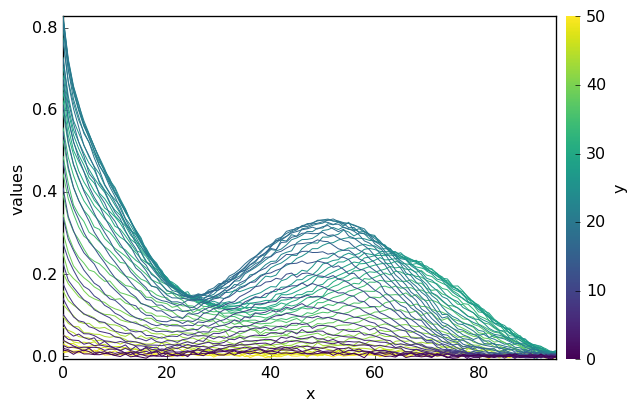

In [5]:
X.plot()

The original dataset is the 'm1' matrix and does not contain information as to the
actual elution time, wavelength,
and data units. Hence, the resulting NDDataset has no coordinates and on the plot,
only the matrix line and row
indexes are indicated. For the clarity of the tutorial, we add: (i) a proper title
to the data, (ii)
the default coordinates (index) do the NDDataset and (iii) a proper name for these
coordinates:

In [6]:
X.title = "absorbance"
X.set_coordset(None, None)
X.set_coordtitles(y="elution time", x="wavelength")
X

NDDataset: [float64] unitless (shape: (y:51, x:96))

From now on, these names will be taken into account by Scpy in the plots as well as
in the analysis treatments
(PCA, EFA, MCR-ALs, ...). For instance to plot X as a surface:

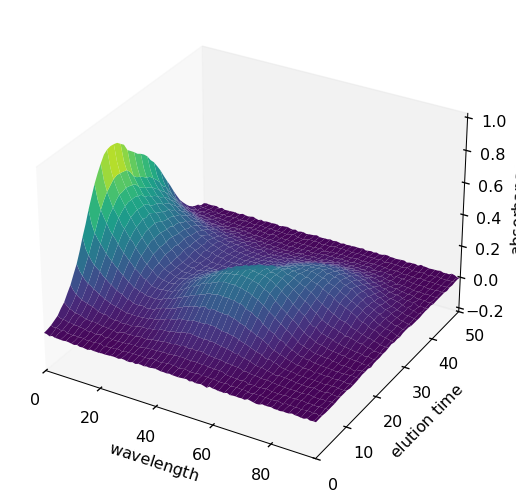

In [7]:
surf = X.plot_surface(linewidth=0.0, figsize=(10, 5), autolayout=False)

## Initial guess and MCR ALS optimization

The ALS optimization of the MCR equation above requires the input of a guess for
either the concentration matrix
$C_0$ or the spectra matrix $S^t_0$. Given the data matrix $X$, the lacking initial
matrix ($S^t_0$ or $C_0$,
respectively) is computed by:
$$ S^t_0 = \left( C_0^tC_0 \right)^{-1} C_0^t X $$

or

$$ C_0 = X {S^t_0}^t  \left( S_0^t {S_0^t}^t \right)^{-1} $$

### Case of initial spectral profiles
The matrix spure provided in the initial dataset is a guess for the spectral profiles.
Let's name it 'St0',
and plot it:

<Matplotlib Axes object>

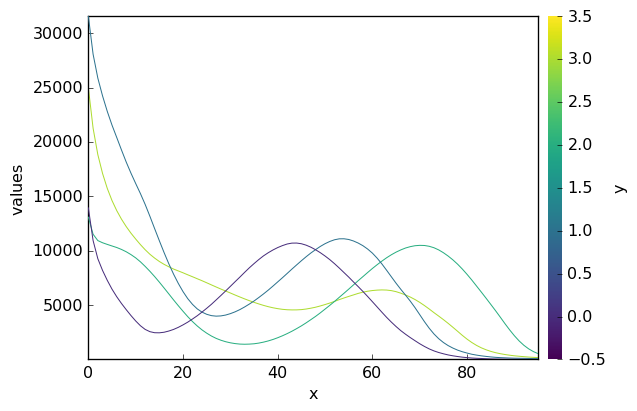

In [8]:
St0 = A[3]
St0.plot()

Note that, again, no information has been given as to the ordinate and abscissa data.
We could add them as previously
but this is not very important. The key point is that the 'wavelength' dimension is
compatible with the data 'X',
which is indeed the case (both have a length of 95). If it was not, an error would be
generated in the following.

#### ALS Optimization
With this guess 'St0' and the dataset 'X' we can create a MCRALS object. At this point
of the tutorial, we will use
all the default parameters.

First, we create an instance of a MCRALS object:

In [9]:
mcr = scp.MCRALS(log_level="INFO")

The `fit` method of `mcr` is now used to start the iteration process.
As the log level has been set to  "INFO" at the MCRALS instance creation,
so we have a summary of the ALS iterations

In [10]:
mcr.fit(X, St0)

 Spectra profile initialized with 4 components


 Initial concentration profile computed


 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000442        0.002807      -97.747926


   2        0.000433        0.002805       -0.048763


 converged !


The optimization has converged within few iterations. The figures reported for each
iteration are defined as follows:

- 'Error/PCA' is the standard deviation of the residuals with respect to data
reconstructed by a PCA with as many
components as pure species (4 in this example),

- 'Error/exp': is the standard deviation of the residuals with respect to the
experimental data X,

- '%change': is the percent change of 'Error/exp' between 2 iterations

The default is to stop when this %change between two iteration is negative (so that
the solution is improving),
but with an absolute value lower than 0.1% (so that the improvement is considered
negligible). This parameter -
as well as several other parameters affecting the ALS optimization can be changed by
the setting the 'tol' value.
For instance:

In [11]:
mcr.tol = 0.01
mcr.fit(X, St0)

 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000442        0.002807      -97.747926


   2        0.000433        0.002805       -0.048763


   3        0.000429        0.002805       -0.022012


   4        0.000428        0.002804       -0.008682


 converged !


As could be expected more iterations have been necessary to reach this stricter
convergence criterion.  The other
convergence criterion that can be fixed by the user is 'maxdiv', the maximum number
of successive diverging
iterations. It is set to 5 by default and allows for stopping the ALS algorithm when
it is no converging.
If for instance the 'tol' is set very low, the optimization will be stopped when
either the maximum number
of iterations is reached (max_iter, 50 by default) or when no improvement is during 5
successive iterations (maxdiv).

In [12]:
mcr.tol = 0.001
mcr.fit(X, St0)

 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000442        0.002807      -97.747926


   2        0.000433        0.002805       -0.048763


   3        0.000429        0.002805       -0.022012


   4        0.000428        0.002804       -0.008682


   5        0.000427        0.002804       -0.003700


   6        0.000427        0.002804       -0.000845


 converged !


#### More information about the MCRALS estimator

##### To get help about the different configuration parameters

In [13]:
# help(mcr)

In [14]:
# It is possible to chain fit runs, without recomputing everything for example for
# optimization of some parameters

mcr = scp.MCRALS(tol=0.001, log_level="INFO")
_ = mcr.fit(X, St0)

 Spectra profile initialized with 4 components


 Initial concentration profile computed


 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000442        0.002807      -97.747926


   2        0.000433        0.002805       -0.048763


   3        0.000429        0.002805       -0.022012


   4        0.000428        0.002804       -0.008682


   5        0.000427        0.002804       -0.003700


   6        0.000427        0.002804       -0.000845


 converged !


In [15]:
mcr1 = scp.MCRALS(tol=0.1, log_level="INFO")
_ = mcr1.fit(X, St0)

 Spectra profile initialized with 4 components


 Initial concentration profile computed


 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000442        0.002807      -97.747926


   2        0.000433        0.002805       -0.048763


 converged !


In [16]:
mcr1.tol = 0.01
_ = mcr1.fit(
    X, (mcr1.C.copy(), mcr1.St.copy())
)  # reuse C and ST computed at the previous run
print("second run with the output of the first")

 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000429        0.002805      -97.749519


   2        0.000428        0.002804       -0.008682


 converged !


second run with the output of the first


In [17]:
mcr1.tol = 0.001
_ = mcr1.fit(X, (mcr1.C, mcr1.St))
print("third run with the output of the second")

 ***           ALS optimisation log            ***


 #iter     RSE / PCA        RSE / Exp      %change


 -------------------------------------------------


   1        0.000427        0.002804      -97.749798


   2        0.000427        0.002804       -0.000845


 converged !


third run with the output of the second


Below we compare the outputs of the initial run (red) and final run (blue).

<Matplotlib Axes object>

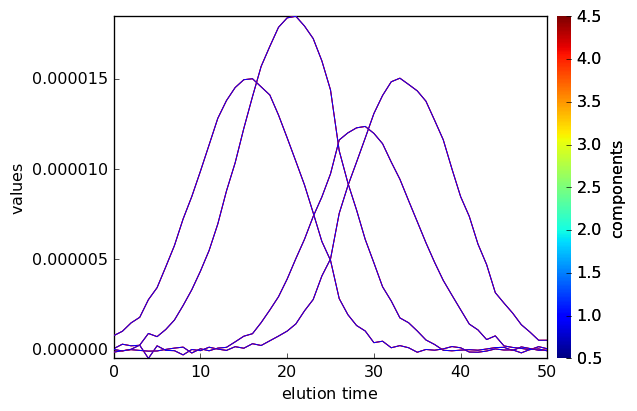

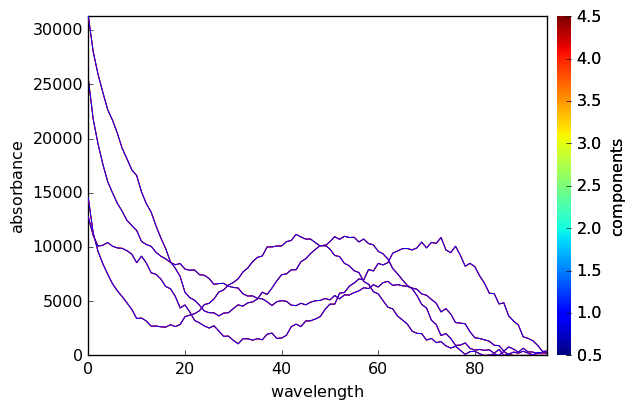

In [18]:
mcr.C.T.plot(cmap=None, color="red")
mcr1.C.T.plot(clear=False, cmap=None, color="blue")

mcr.St.plot(cmap=None, color="red")
mcr1.St.plot(clear=False, cmap=None, color="blue")

#### Solutions

The solutions of the MCR ALS optimization are the optimized concentration (C) and pure
spectra (St) datasets. They are stored as in the `C` and `St` attribute of the MCRAL object.
As MCRALS is derived from to the `DecompositionAnalysis` class, C and St can also be obtained
by `MCRALS.transform()` and MCRALS.components, respectively.

 Let's generate a MCRALS
 object with the default settings, and get the solution datasets C and St. Note that
 the default log_level is "WARNING" so we do not see any output here.

In [19]:
mcr1 = scp.MCRALS()
mcr1.fit(X, St0)

As the dimensions of C are such that the rows' direction (C.y) corresponds to the
elution time and the columns'
direction (C.x) correspond to the four pure species, it is necessary to transpose
it before plotting in order
to plot the concentration vs. the elution time.

<Matplotlib Axes object>

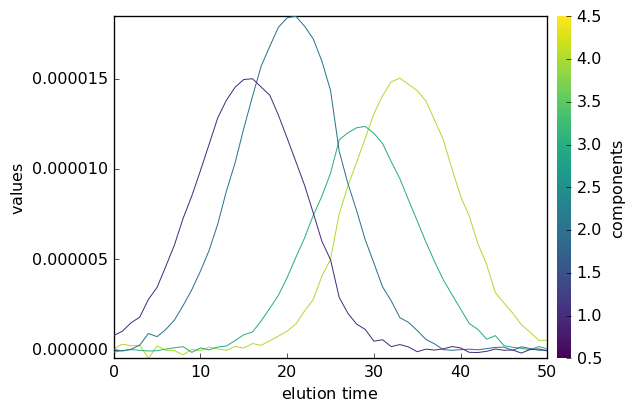

In [20]:
mcr1.C.T.plot()

On the other hand, the spectra of the pure species can be plotted directly:

<Matplotlib Axes object>

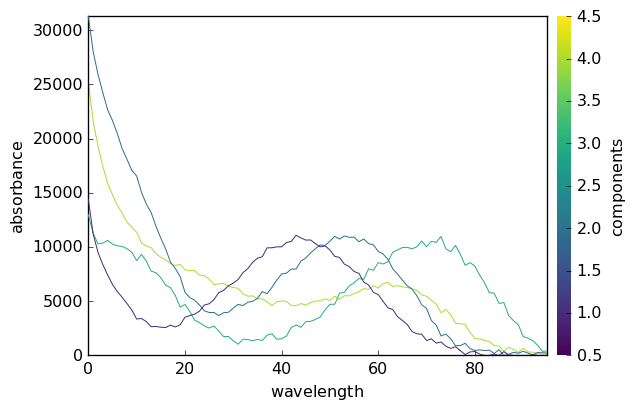

In [21]:
mcr1.St.plot()

#### A basic illustration of the rotational ambiguity
We have thus obtained the elution profiles of the four pure species. Note that the
'concentration' values are very
low. This results from the fact that the absorbance values in X are on the order of
0-1 while the absorbance of
the initial pure spectra are of the order of 10^4. As can be seen above,
the absorbance of the final spectra is of
the same order of magnitude.

It is possible to normalize the intensity of the spectral profiles by setting the
'normSpec' parameter to True.
With this option, the spectra are normalized such that their euclidean norm is 1.
The other normalization option is
normspec = 'max', whereby the maximum intensity of the spectra is 1. Let's look at
the effect of
both normalizations:

<Matplotlib Axes object>

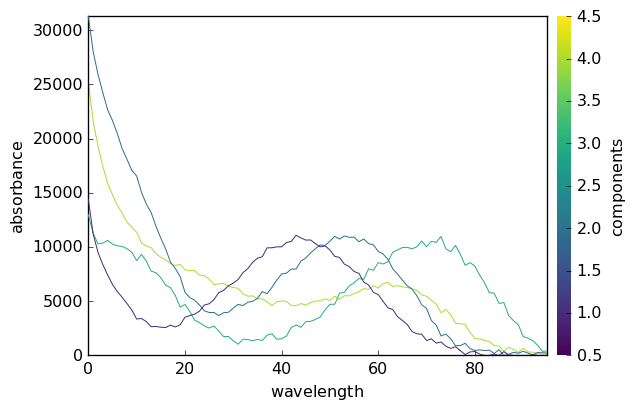

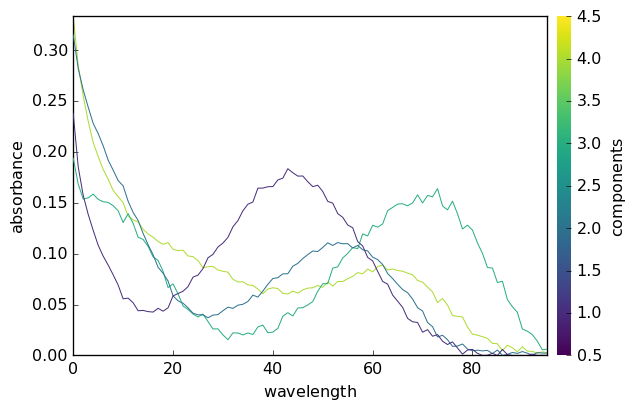

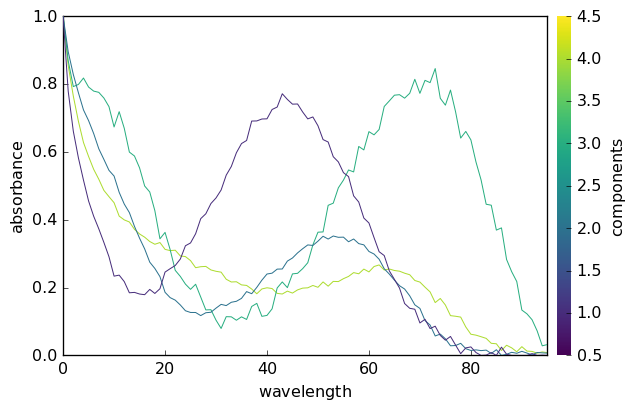

In [22]:
mcr2 = scp.MCRALS(normSpec="euclid")
mcr2.fit(X, St0)

mcr3 = scp.MCRALS(normSpec="max")
mcr3.fit(X, St0)

mcr1.St.plot()
mcr2.St.plot()
mcr3.St.plot()

<Matplotlib Axes object>

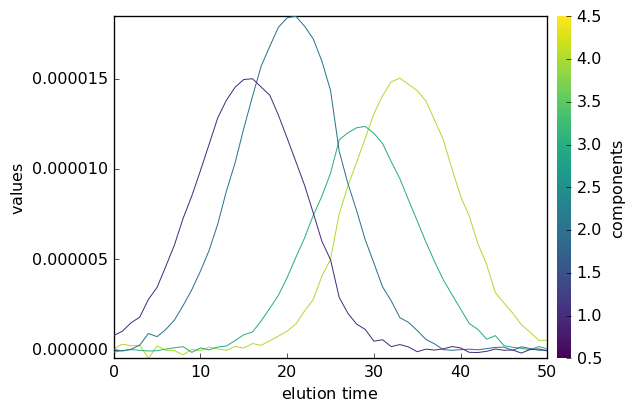

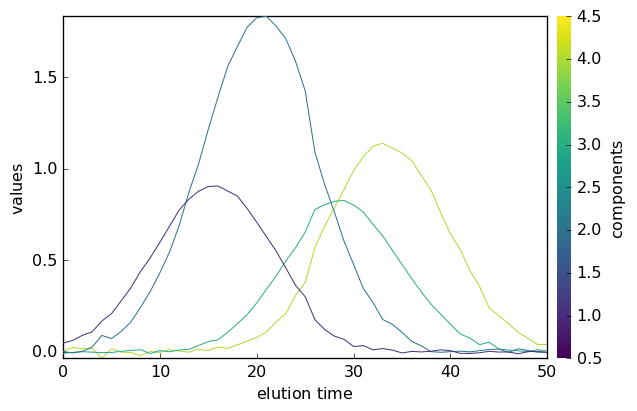

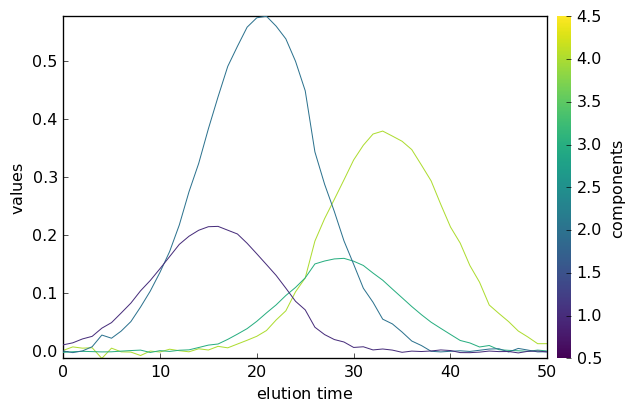

In [23]:
mcr1.C.T.plot()
mcr2.C.T.plot()
mcr3.C.T.plot()

It is clear that the normalization affects the relative intensity of the spectra and
of the concentration.
This is a basic example of the well known rotational ambiguity of the MCS ALS
solutions.

### Guessing the concentration profile with PCA + EFA

Generally, in MCR ALS, the initial guess cannot be obtained independently of the
experimental data 'x'.
In such a case, one has to rely on 'X' to obtained (i) the number of pure species
and (ii) their initial
concentrations or spectral profiles. The number of pure species can be assessed by
carrying out a PCA on the
data while the concentrations or spectral profiles can be estimated using procedures
such EFA of SIMPLISMA.
The following will illustrate the use of PCA followed by EFA

#### Use of PCA to assess the number of pure species

Let's first analyse our dataset using PCA and plot a screeplot:

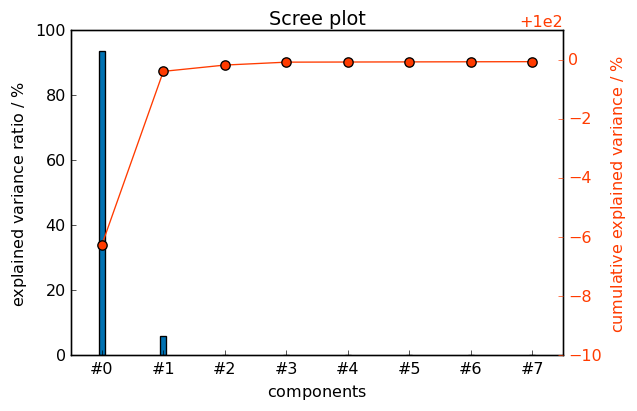

<Figure size 652.8x427.2 with 0 Axes>

In [24]:
pca = scp.PCA(n_components=8)
pca.fit(X)
pca.printev()
_ = pca.screeplot()

The number of significant PC's is clearly larger or equal to 2. It is, however,
difficult to determine whether
it should be set to 3 or 4...  Let's look at the score and loading matrices:


<Matplotlib Axes object>

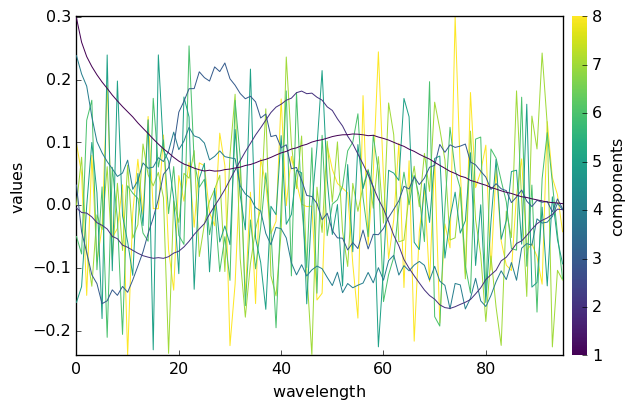

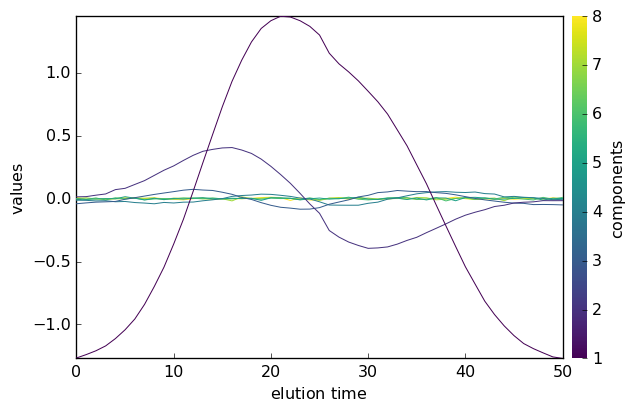

In [25]:
scores = pca.transform()
pca.loadings.plot()
scores.T.plot()

Examination of the scores and loadings indicate that the 4th component has structured,
nonrandom scores and loadings.
Hence, we will fix the number of pure species to 4.

#### Determination of initial concentrations using EFA

Once the number of components has been determined, the initial concentration matrix
is obtained very easily using EFA:


<Matplotlib Axes object>

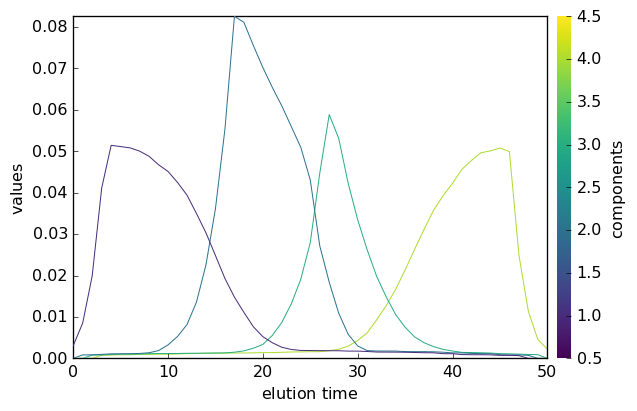

In [26]:
efa = scp.EFA()
efa.fit(X)
efa.n_components = 4
C0 = efa.transform()
C0.T.plot()

The MCR ALS can then be launched using this new guess:

In [27]:
mcr4 = scp.MCRALS(max_iter=100, normSpec="euclid")
mcr4.fit(X, C0)

<Matplotlib Axes object>

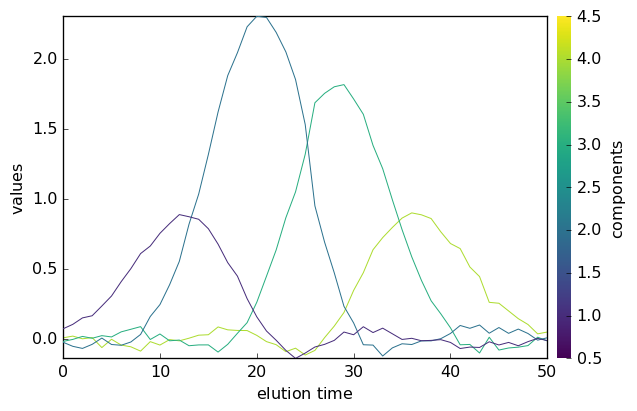

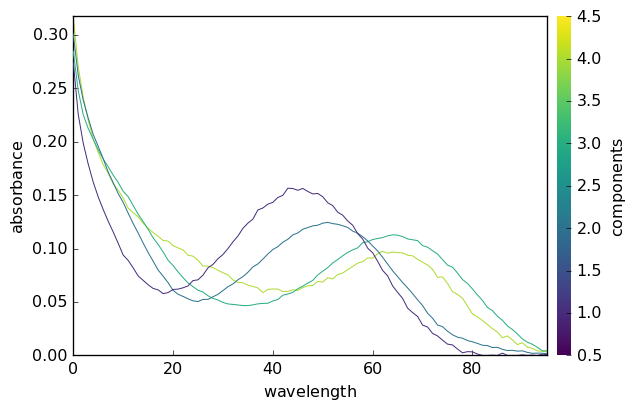

In [28]:
mcr4.C.T.plot()
mcr4.St.plot()

## Augmented datasets

The 'MATRIX' dataset is a columnwise augmented dataset consisting into 5 successive
runs:

In [29]:
A[1]

NDDataset: [float64] unitless (shape: (y:204, x:96))

Let's plot it as a surface and as a map:

<Matplotlib Axes object>

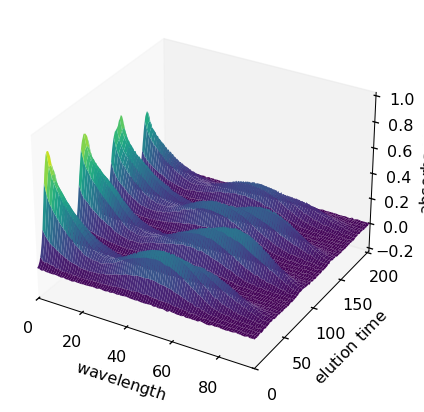

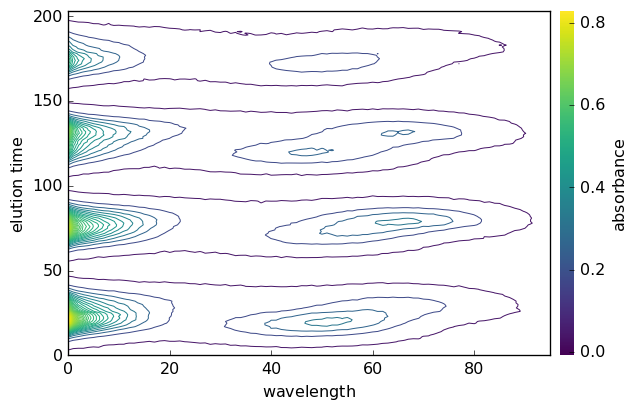

In [30]:
X2 = A[1]
X2.title = "absorbance"
X2.set_coordset(None, None)
X2.set_coordtitles(y="elution time", x="wavelength")
surf = X2.plot_surface(linewidth=0.0, ccount=100, figsize=(8, 4), autolayout=False)
X2.plot(method="map")

In [31]:
mcr5 = scp.MCRALS(unimodConc=[])
mcr5.fit(X2, St0)

<Matplotlib Axes object>

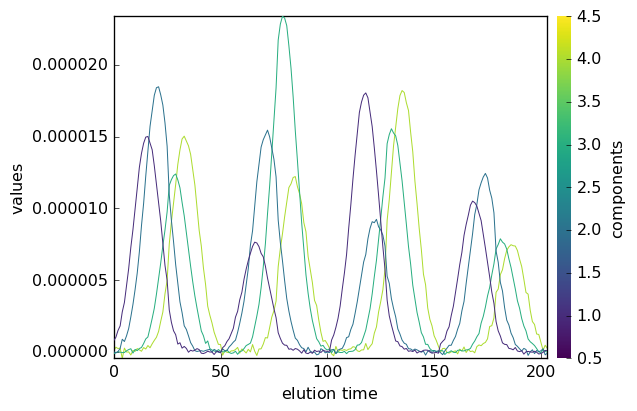

In [32]:
mcr5.C.T.plot()

<Matplotlib Axes object>

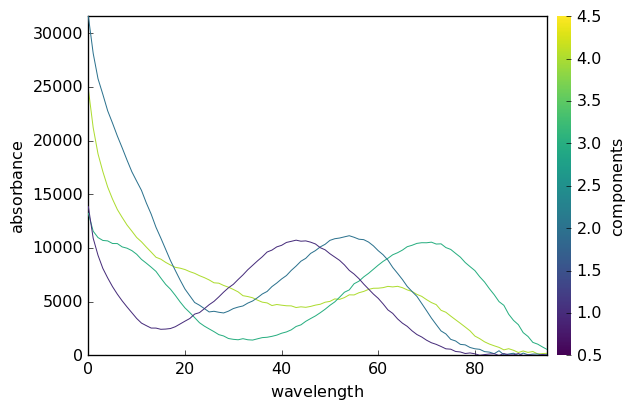

In [33]:
mcr5.St.plot()

[To be continued...]